In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.functional as F
import torch
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from training import Trainer
from load_data import LFWDataLoader

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
dl = LFWDataLoader(batch_size=24)

train_ds, train_dl = dl.train_dataset, dl.train_dataloader
val_ds, val_dl = dl.val_dataset, dl.val_dataloader
test_ds, test_dl = dl.test_dataset, dl.test_dataloader

(21172, 3, 125, 94)
(21172, 3, 125, 94)
(1323, 3, 125, 94)
(1324, 3, 125, 94)


C:\Users\rwbak\AppData\Local\Temp\ipykernel_28872\2152170677.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 20000 + 1) instead
  random = np.random.random_integers(0,20000)


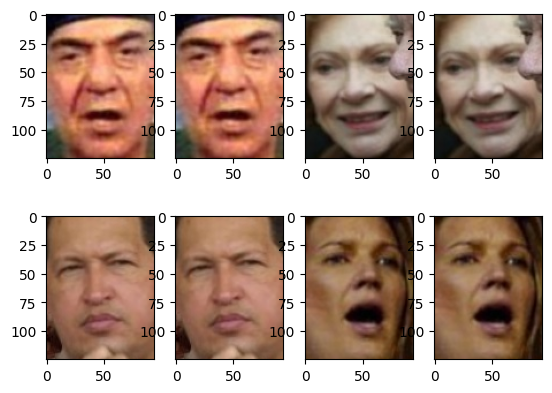

In [4]:
f = plt.figure()
random = np.random.random_integers(0,20000)
for i, (data, label) in enumerate(train_ds):
    if i < random:
        continue
    try:
        f.add_subplot(2,4,2*(i-random)+1)
        plt.imshow(data.to('cpu').permute(1, 2, 0))
        f.add_subplot(2,4,2*(i-random)+2)
        plt.imshow(label.to('cpu').permute(1, 2, 0))
    except:
        break

In [63]:
from model import Encoder, Decoder, FC_Decoder, AutoEncoder
from loss import LogCoshLoss, PerceptualLoss

latent = 128
hidden = 100

model = AutoEncoder(Encoder(latent),FC_Decoder(latent,hidden))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

optim = torch.optim.Adam(model.parameters(), lr=5e-4)
# optim = torch.optim.Adagrad(model.to(device).parameters(),lr=1e-3,weight_decay=0.97)

trainer = Trainer(model, optim, device, train_dl, val_dl,kl_factor=1e-4,kl_rate=1,kl_max=1e-4, lossfn=PerceptualLoss())
torch.cuda.empty_cache()
mse, kl, total = trainer.train_model(epochs=3,print_every=100)

6616033
EPOCH:  0
Iteration 0, loss = -1.6102
KL Factor: 0.000100
KL 4.2942
Avg Loss on Val: 0.33963775634765625

Iteration 100, loss = -112039088.0000
KL Factor: 0.000100
KL 916538458112.0000
Avg Loss on Val: 9466890831565386.0



KeyboardInterrupt: 

In [57]:
trainer.check_accuracy(loader=test_dl,model=model)

Avg Loss on Val: 0.024641328624316623


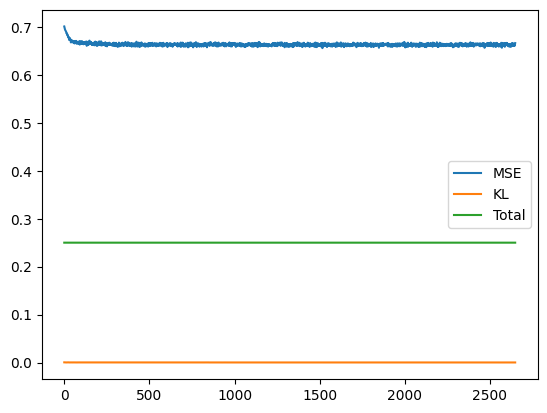

In [58]:
total = np.minimum(total,0.25)
kl = np.minimum(kl,0.25)

plt.plot(range(len(mse)),mse,label='MSE')
plt.plot(range(len(kl)),kl,label='KL')
plt.plot(range(len(total)),total,label='Total')
plt.legend()

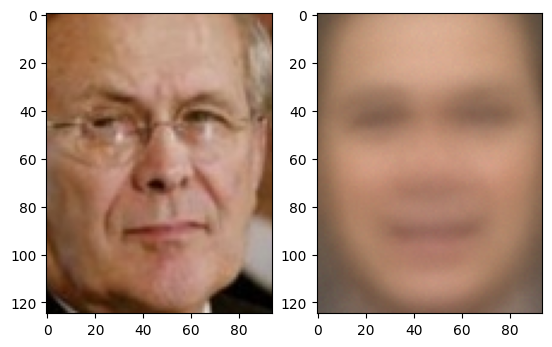

In [59]:
f = plt.figure()
tensor_image,_ = test_ds[20]
f.add_subplot(1,2,1)
plt.imshow(tensor_image.permute(1, 2, 0))
model.eval()
with torch.no_grad():
    tensor_image = tensor_image.unsqueeze(0)
    scores,_ = model(tensor_image.to(device))

f.add_subplot(1,2,2)
scores = scores.squeeze(0)
plt.imshow(scores.to('cpu').permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


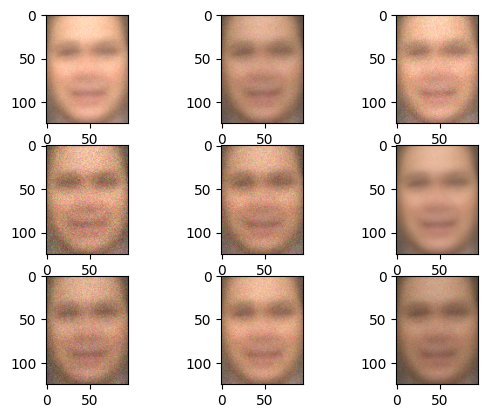

In [60]:
encoder = model.encoder
decoder = model.decoder
idx = np.random.randint(0,1000)
tensor_image,_ = test_ds[idx]
tensor_image = tensor_image.unsqueeze(0)
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()
with torch.no_grad():
    randomData = torch.Tensor(np.random.normal(latent_mu,3*np.absolute(latent_var),(9,latent)))
    scores = model.decoder(randomData.to(device))
f = plt.figure()
for i in range(9):
    f.add_subplot(3,3,i+1)
    plt.imshow(scores[i].squeeze(0).to('cpu').permute(1, 2, 0))

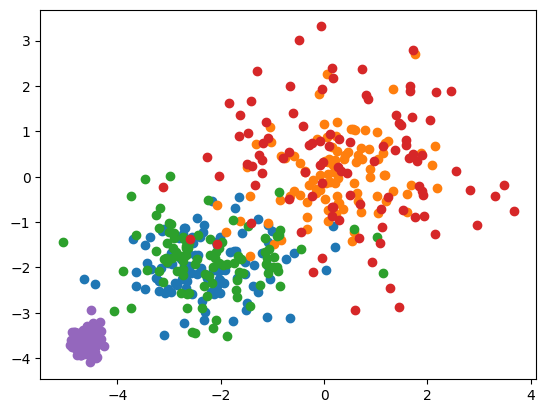

In [61]:
encoder = model.encoder
tensor_image,_ = test_ds[0:2]
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()
for i in range(5):
    latent_dist = torch.distributions.Normal(latent_mu[0,i],torch.abs(latent_var[0,i]))
    latent_dist_2 = torch.distributions.Normal(latent_mu[1,i],torch.abs(latent_var[1,i]))
    # plt.scatter(np.abs(latent_var[:,i]),np.abs(latent_var[:,i+1]))
    plot1,plot2 = [],[]
    for i in range(100):
        plot1.append(latent_dist.rsample())
        plot2.append(latent_dist_2.rsample())
    plt.scatter(plot1,plot2)

In [11]:
import gc 
model = 1
del model 
gc.collect()
plt.close()
with torch.no_grad():
    torch.cuda.empty_cache()